Tenga en cuenta que el archivo `unet_model.py` utilizado en este tutorial es solo para demostración.
El autor original de `unet_model.py` es Supervisely.
Consultar README de pv-vision y `unet_model.py` para conocer los términos de uso.
Puede cambiar el modelo aquí con otros pesos para uso personal.


In [1]:
# Importar librerías

import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import requests
import copy

from unet_model import construct_unet

from PIL import Image
from imutils.paths import list_images

In [2]:
# Importar Model Handler
from pv_vision.nn import ModelHandler

In [3]:
# Carpeta de imágenes
#images = [cv.imread(file) for file in list_images('/home/franklin/PVDefectDetect/TestsPV-vision/examples/crack_segmentation/img_for_prediction')]
#images = [cv.imread(file) for file in list_images('/home/franklin/PVDefectDetect/Test_crack')]
images = [cv.imread(file) for file in list_images('D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/PVDefectDetect/Test_crack')]

# Carpeta con imágenes editadas con ImageJ /home/franklin/supervisely/Croped_images
#images = [cv.imread(file) for file in list_images('/home/franklin/supervisely/Croped_images')]


In [4]:
# Verificar que las imágenes se cargaron correctamente
print(f'Número de imágenes: {len(images)}')


Número de imágenes: 15


El siguiente código define una clase `myDataset` que hereda de la clase `Dataset` de PyTorch. Esta clase se utiliza para cargar y transformar las imágenes que se pasarán al modelo. La transformación se aplica a cada imagen cuando se accede a ella, no todas a la vez al principio. Esto es más eficiente en términos de memoria, especialmente cuando se trabaja con conjuntos de datos grandes.

In [5]:
# Definir una clase personalizada que hereda de Dataset
class myDataset(Dataset):
    # El método de inicialización se llama cuando se crea una instancia de la clase
    def __init__(self, images, transform):
        # Guardar las imágenes y la transformación como atributos de la instancia
        self.images = images
        self.transform = transform

    # El método __len__ devuelve el número de elementos en el conjunto de datos
    def __len__(self):
        return len(self.images)

    # El método __getitem__ se utiliza para obtener un elemento del conjunto de datos
    def __getitem__(self, idx):
        # Redimensionar la imagen al tamaño deseado
        image = cv.resize(self.images[idx], (256, 256))
        # Aplicar la transformación a la imagen
        image = self.transform(image)
        
        # Devolver la imagen transformada
        return image

El siguiente código define una transformación que se aplica a las imágenes antes de pasarlas al modelo. La transformación consta de dos pasos: convertir la imagen a un tensor de PyTorch y normalizar los valores de los píxeles. Luego, se crea una instancia de la clase `myDataset` que se utiliza para cargar y transformar las imágenes.

In [6]:
# Definir la transformación de las imágenes que se pasará al manejador del modelo
transform = transforms.Compose([
    # Convertir la imagen a un tensor de PyTorch y escalar los valores de los píxeles entre 0 y 1
    transforms.ToTensor(),
    # Normalizar cada canal de color de la imagen. Los valores de la media y la desviación estándar se especifican para cada canal (RGB). 
    # Estos valores son los valores de media y desviación estándar del conjunto de datos ImageNet.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Crear una instancia de la clase myDataset. Esta clase es un tipo personalizado de Dataset que se utiliza para cargar y transformar las imágenes.
# La lista de imágenes y la transformación compuesta se pasan como argumentos al inicializar el conjunto de datos.
imgset = myDataset(images, transform)

In [7]:
# Carpeta de pesos del modelo

#weight_path = '/home/franklin/supervisely/neural network weights/crack_segmentation/unet_oversample_low_final_model_for_paper/model.pt'
weight_path = 'D:/Documentos/PV_Vision/Neural_Network_W/crack_segmentation/unet_oversample_low_final_model_for_paper/model.pt'

In [8]:
# Definir el dispositivo en el que se ejecutará el modelo. Si hay una GPU disponible, se utilizará. De lo contrario, se utilizará la CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo: {device}')

# Crear una instancia del modelo U-Net con 5 canales de salida. 
# El número de canales de salida generalmente corresponde al número de clases que el modelo está diseñado para predecir.
unet = construct_unet(5)

# Envolver el modelo en un objeto DataParallel. 
# Esto permite que el modelo se ejecute en paralelo en múltiples GPUs, si están disponibles.
unet = DataParallel(unet)

Dispositivo: cuda:0




Este código define el dispositivo en el que se ejecutará el modelo (GPU si está disponible, de lo contrario CPU), crea una instancia del modelo U-Net, y luego envuelve el modelo en un objeto `DataParallel` para permitir la ejecución en paralelo en múltiples GPUs.

In [9]:
# Inicializar el manejador del modelo (ModelHandler). 
# Este objeto se encargará de la gestión del modelo, incluyendo la carga de los datos, la ejecución del modelo y el almacenamiento de los resultados.
modelhandler = ModelHandler(
    # El modelo que se va a utilizar. En este caso, es la instancia de U-Net que se ha creado anteriormente.
    model=unet,
    # El conjunto de datos que se utilizará para las pruebas. En este caso, es el conjunto de imágenes que se ha cargado y transformado anteriormente.
    test_dataset=imgset,
    # Indica que sólo se realizarán predicciones, no se entrenará el modelo.
    predict_only=True,
    # El tamaño del lote que se utilizará durante la validación. En este caso, se procesarán 2 imágenes a la vez.
    batch_size_val=2,
    # El dispositivo en el que se ejecutará el modelo. En este caso, es el dispositivo que hemos definido anteriormente (GPU si está disponible, de lo contrario CPU).
    device=device,
    # El directorio donde se guardarán los resultados. En este caso, los resultados se guardarán en un directorio llamado 'output'.
    save_dir='output',
    # El nombre que se utilizará para guardar los resultados. En este caso, los resultados se guardarán con el nombre 'unet_prediction'.
    save_name='unet_prediction'
)

# Cargar los pesos del modelo desde el archivo especificado por 'weight_path'.
# Esto permite utilizar un modelo que ha sido entrenado previamente, en lugar de tener que entrenar el modelo desde cero.
modelhandler.load_model(weight_path)



Este código inicializa un objeto `ModelHandler` que se encargará de la gestión del modelo, incluyendo la carga de los datos, la ejecución del modelo y el almacenamiento de los resultados. Luego, carga los pesos del modelo desde un archivo especificado.

In [10]:
# Ejecutar el modelo en el conjunto de datos de prueba.
# Esto generará predicciones para cada imagen en el conjunto de datos.
masks = modelhandler.predict(save=True)

100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


In [11]:
# Se definió una transformación para redimensionar las imágenes a 256x256 y convertirlas a tensores de PyTorch.
resize = transforms.Compose([transforms.Resize((256, 256)), transforms.PILToTensor()])

# Se definió un mapa de colores para las diferentes clases de máscaras.
color_map = {
    'dark': (68, 114, 148),
    'cross': (77, 137, 99),
    'crack': (165, 59, 63),
    'busbar': (222, 156, 83)
}

# Se definió una función para obtener las máscaras de las predicciones del modelo.
def get_masks(masks_raw):
    # Se creó una lista vacía para almacenar las máscaras.
    masks_each = []
    # Se aplicó la función softmax a las predicciones del modelo y se obtuvo la clase con la mayor probabilidad para cada píxel.
    masks_all = torch.nn.functional.softmax(torch.from_numpy(masks_raw), dim=1).argmax(dim=1)
    # Para cada máscara en masks_all, se crearon máscaras booleanas para cada clase y se añadieron a la lista masks_each.
    for masks in masks_all:
        busbar = masks==1
        crack = masks==2
        cross = masks==3
        dark = masks==4
        masks_each.append(torch.dstack([busbar, crack, cross, dark]).permute(2, 0, 1))
    return masks_each

# Se definió una función para dibujar las máscaras sobre las imágenes.
def draw_mask(img, masks, colors=color_map, alpha=0.6):
    # Se convirtió la imagen a un objeto de la clase Image de PIL y se redimensionó.
    img = Image.fromarray(img)
    img = resize(img)
    # Se dibujaron las máscaras sobre la imagen con la opacidad especificada y se devolvió la imagen resultante.
    combo = draw_segmentation_masks(img, masks, alpha=alpha, colors=[colors[key] for key in ['busbar', 'crack', 'cross', 'dark']])
    return F.to_pil_image(combo)

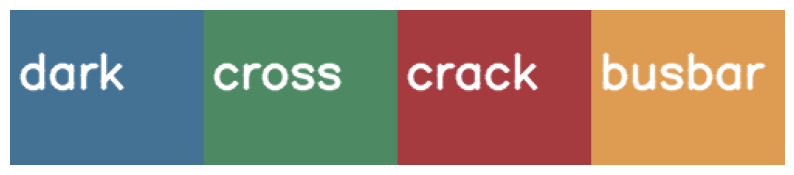

In [12]:
# Mostrar el mapa de colores junto con las clases correspondientes. Cuadros de colores con los nombres de las clases.

# Definir el tamaño de la imagen
height = 100
width = 500

# Crear una imagen en blanco con el tamaño especificado
color_map_img = np.zeros((height, width, 3), dtype=np.uint8)

# Definir el mapa de colores y los nombres de las clases
#color_map = {'dark': (68, 114, 148), 'cross': (77, 137, 99), 'crack': (165, 59, 63), 'busbar': (222, 156, 83)}
class_names = list(color_map.keys())

# Calcular el ancho de cada cuadro de color
color_box_width = width // len(class_names)

# Dibujar los cuadros de color y los nombres de las clases en la imagen
for i, class_name in enumerate(class_names):
    color = color_map[class_name]
    start_x = i * color_box_width
    end_x = (i + 1) * color_box_width
    color_map_img[:, start_x:end_x] = color
    text_x = start_x + 5
    text_y = height // 2
    cv.putText(color_map_img, class_name, (text_x, text_y), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv.LINE_AA)

# Mostrar la imagen
plt.figure(figsize=(10, 5))
plt.imshow(color_map_img)
plt.axis('off')
plt.show()

# cv.imshow('Color Map', color_map_img)
# cv.waitKey(0)
# cv.destroyAllWindows()




Este código define dos funciones: `get_masks` y `draw_mask`. La función `get_masks` toma las predicciones en bruto del modelo y las convierte en máscaras booleanas para cada clase. La función `draw_mask` toma una imagen y las máscaras correspondientes y dibuja las máscaras sobre la imagen.

In [13]:
# Se obtienen las máscaras de las predicciones del modelo.

masks_each = get_masks(masks)

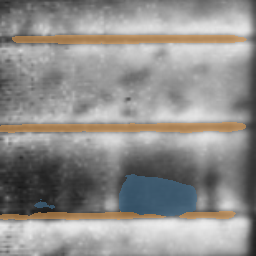

In [14]:
# Se dibujan las máscaras sobre las imágenes originales.
draw_mask(images[13], masks_each[13])

In [25]:
# Se imprime si se encontró grietas (máscara crack): busbar = masks==0; crack = masks==1; cross = masks==2; dark = masks==3
print(f'Píxeles dentro de la clase crack: {masks_each[10][1].sum()}')
print(f'Píxeles dentro de la clase busbar: {masks_each[10][0].sum()}')



Píxeles dentro de la clase crack: 0
Píxeles dentro de la clase busbar: 652


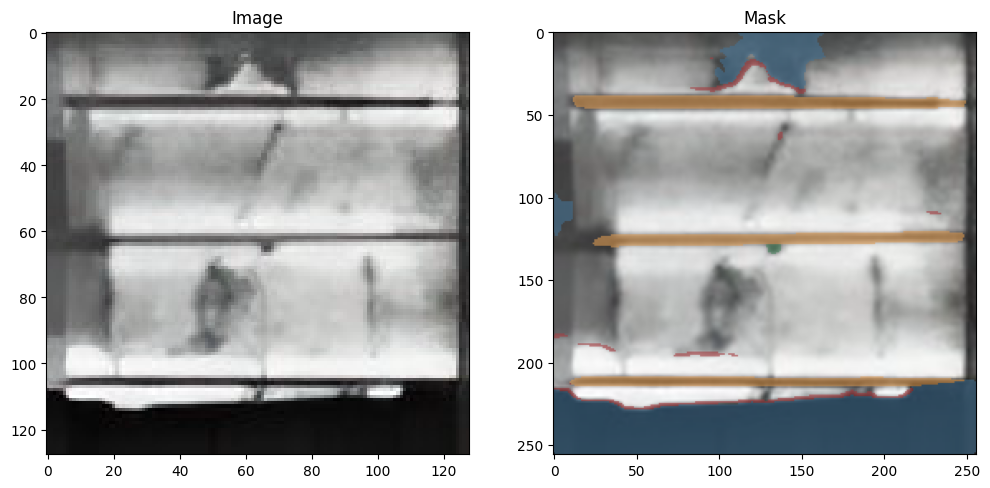

In [44]:
import matplotlib.pyplot as plt

# Se visualizan las imágenes y las máscaras correspondientes.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(images[12])
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(np.array(draw_mask(images[12], masks_each[12])))
plt.title('Mask')

plt.show()


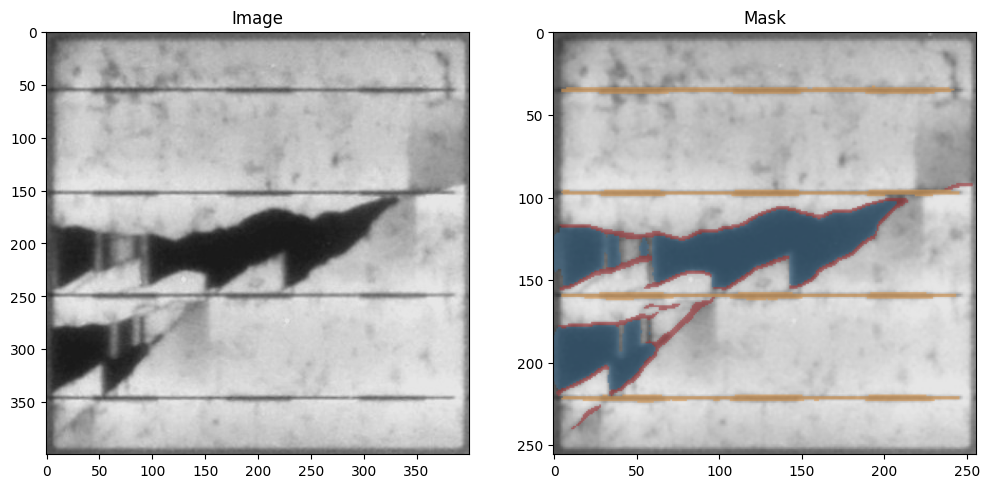

In [16]:
# Se visualizan las imágenes y las máscaras correspondientes.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(images[9])
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(np.array(draw_mask(images[9], masks_each[9])))
plt.title('Mask')

plt.show()

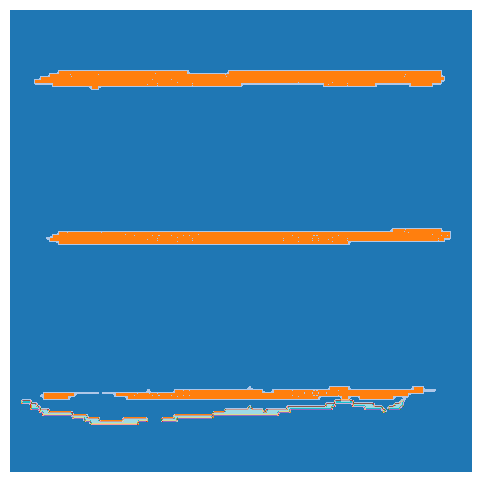

In [67]:
# Crear imagen de anotaciones `annImage` con las máscaras `crack` y `busbar` de las predicciones

# Valores para las clases. 'background': 0, 'busbar': 10, 'crack': 100
class_values = [0, 10, 100]
# Obtener las dimensiones de las máscaras
mask_shape = masks_each[11][0].shape

# Imagen de anotaciones con las máscaras `crack` y `busbar` de las predicciones
annImage = np.zeros(mask_shape, dtype=np.uint8)

# Para cada clase, aislar los píxeles de esa clase y asignarles el valor correspondiente
# píxeles de la clase `busbar` se asignan el valor 10
annImage[masks_each[11][0]] = class_values[1]
# píxeles de la clase `crack` se asignan el valor 100
annImage[masks_each[11][1]] = class_values[2]

# Redimensionar annImage para que coincida con el tamaño de la imagen original
annImage = cv.resize(annImage, (images[11].shape[1], images[11].shape[0]), interpolation=cv.INTER_NEAREST)
images_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Paneles/Panel_260W'

# Guardar la imagen de anotaciones en un archivo junto con la imagen original
cv.imwrite(f'{images_path}/annImage11.png', annImage)
cv.imwrite(f'{images_path}/Image11.png', images[11])

# Visualizar la imagen de anotaciones
plt.figure(figsize=(6, 6))
plt.imshow(annImage, cmap='tab20')
plt.axis('off')
plt.show()

Extracción de características de las grietas: porcentaje de área inactiva de la celda

In [52]:
from pv_vision.crack_analysis.crackcell import CrackCell
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [59]:
img_path = images_path + '/Image11.png'
ann_path = images_path + '/annImage11.png'

# Crear una instancia de CrackCell
crackcell = CrackCell(img_path,
                      ann_path,
                      crack_inx = 100,
                      busbar_inx = 10,
                      busbar_num=3)


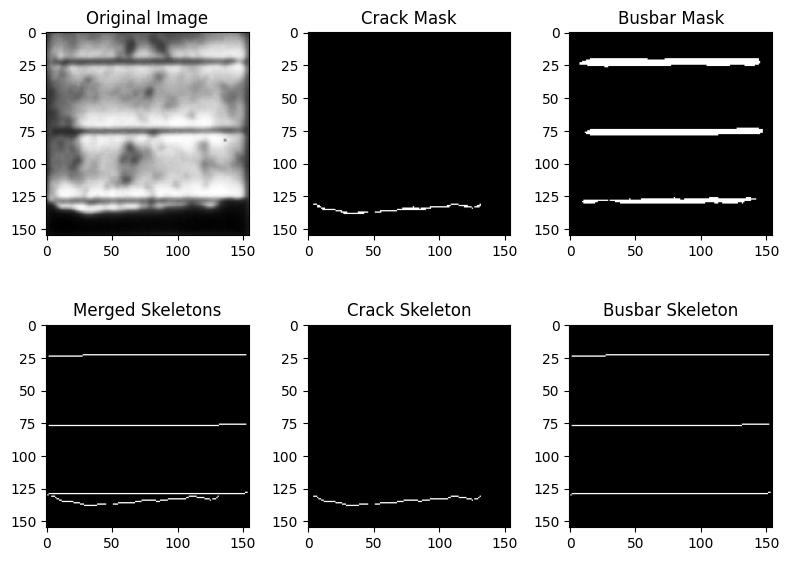

In [60]:
# Visualización de la imagen original y las máscaras de crack y busbar
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
axes[0, 0].imshow(crackcell.img, 'gray')
axes[0, 0].set_title('Original Image')
axes[0, 1].imshow(crackcell.crack, 'gray')
axes[0, 1].set_title('Crack Mask')
axes[0, 2].imshow(crackcell.busbar, 'gray')
axes[0, 2].set_title('Busbar Mask')

axes[1, 0].imshow(crackcell.ske_merge, 'gray')
axes[1, 0].set_title('Merged Skeletons')
axes[1, 1].imshow(crackcell.ske_crack, 'gray')
axes[1, 1].set_title('Crack Skeleton')
axes[1, 2].imshow(crackcell.ske_busbar, 'gray')
axes[1, 2].set_title('Busbar Skeleton')

plt.tight_layout()

9.89802289281998 %


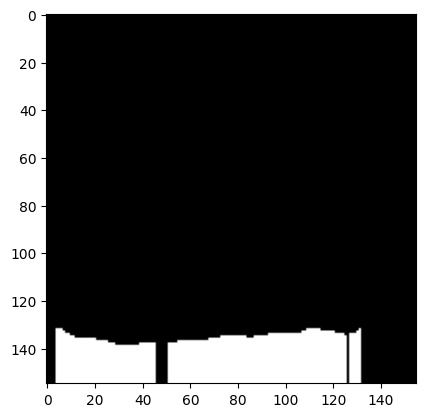

In [68]:
# Extracción del área inactiva
inactive_area, inactive_prop = crackcell.extract_inactive_area()
plt.imshow(inactive_area, "gray")
print("{} %".format(inactive_prop*100))

In [62]:
# Extracción de la longitud de la grieta
crack_length = crackcell.extract_crack_length()
print("{} pixels".format(crack_length))

122 pixels


In [64]:
# Extracción del brillo
# Existen tres modos
# 1. avg_all: brillo promedio de toda la imagen
# 2. avg_inactive: brillo promedio de la región inactiva y trata el área actica como 1
# 3. avg_inactive_only: brillo promedio solo del área inactiva y devuelve 1 para las celdas intactas

brightness = crackcell.extract_brightness(mode='avg_inactive_only')
brightness

0.09928263988522239

In [65]:
# Extracción de todas las funciones a la vez
crackcell.extract_features()

{'inactive_prop': 0.0989802289281998,
 'crack_length': 122,
 'brightness_cell': 0.5595263104201098,
 'brightness_inactive_only': 0.09928263988522239}

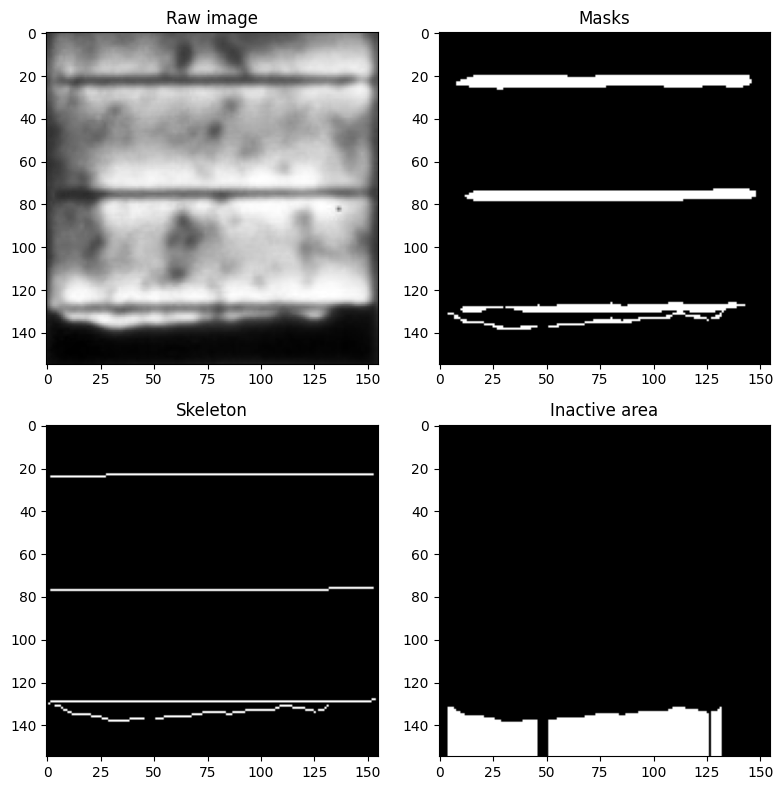

In [66]:
crackcell.plot()